<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-libs" data-toc-modified-id="import-libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import libs</a></span></li><li><span><a href="#Parse-Lammps-dump-file" data-toc-modified-id="Parse-Lammps-dump-file-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Parse Lammps dump file</a></span></li><li><span><a href="#Energy" data-toc-modified-id="Energy-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Energy</a></span><ul class="toc-item"><li><span><a href="#main()" data-toc-modified-id="main()-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>main()</a></span></li></ul></li></ul></div>

# import libs

In [5]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
list(map(lambda x:sys.path.append(x), confParser['input files']['lib_path'].split()))
from dscribe.descriptors import SOAP, ACSF
import ase
import ase.io
import ase.build
from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot as plt
if not eval(confParser['flags']['RemoteMachine']):
    plt.rc('text', usetex=True)
import sklearn
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
from scipy.interpolate import Rbf


#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)

#--- increase width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

conf. file sections: ['flags', 'input files', 'descriptors', 'neural net', 'neural net classification', 'neural net regression', 'gnn', 'NeuralNets', 'ml mc']


# Parse Lammps dump file

In [87]:
class ParseConfiguration:
    '''
    Parse k-art configuration file
    '''
    
    def __init__(self,confParser,verbose=False):

        #--- fetch parameters defect_file
        self.datFile  = '%s/%s'%(confParser['input files']['input_path'],confParser['input files']['diffusion_file'])
        self.lib_path = confParser['input files']['lib_path'].split()[0]
        
        self.verbose  = verbose

    def Parse(self,fp,outpt):
        #--- parse dump: call ovito
        t0            = time.time()
        outpt_headers = 'dumpFile/calcResults.txt'
        if self.verbose:
            print('parsing %s'%(fp))
        !ovitos $self.lib_path/OvitosCna.py $fp $outpt 1 7 $outpt_headers
        if self.verbose:
            print('output dump file=%s s'%(time.time()-t0))

        #--- parse dump files
        t0=time.time()
        self.lmpData  = lp.ReadDumpFile( '%s'%(outpt) ) 
        self.lmpData.GetCords( ncount = sys.maxsize)
        if self.verbose:
            print('elapsed time=%s s'%(time.time()-t0))
            print('time steps:',self.lmpData.coord_atoms_broken.keys())
            display(self.lmpData.coord_atoms_broken[0].head())

        #--- add timescales
        self.lmpData.times = np.loadtxt(self.datFile)[:,0]

        #--- parse headers
        data             =  np.loadtxt(outpt_headers)
        if data.shape[1] == 4:
            self.lmpData.headers = pd.DataFrame(data,columns=["Barrier", "Energy", "Step", "Time"])
        elif data.shape[1] == 2:
            self.lmpData.headers = pd.DataFrame(data,columns=["Step", "Time"])


    def WignerSeitz(self,fp,reference_file):
        '''
        perform Wigner-Seitz algorithm
        '''
        outpt = 'dumpFile/dump_defect.xyz'

        #--- parse dump: call ovito
        if self.verbose:
            print('input=',fp)
        t0=time.time()
        !ovitos $self.lib_path/OvitosCna.py $fp $outpt 1 11 $reference_file
        if self.verbose:
            print('output dump file=%s s'%(time.time()-t0))

        #--- parse dump files
        if self.verbose:
            print('parsing %s'%(outpt))
        t0=time.time()
        self.lmpData_defect = lp.ReadDumpFile( '%s'%(outpt) ) 
        self.lmpData_defect.GetCords( ncount = sys.maxsize)
        if self.verbose:
            print('elapsed time=%s s'%(time.time()-t0))

        if self.verbose:
            print('time steps:',self.lmpData_defect.coord_atoms_broken.keys())
            display(self.lmpData_defect.coord_atoms_broken[0].head())

        #--- add timescales
        self.lmpData_defect.times = np.loadtxt(self.datFile)[:,0]


    def Print(self,fout):
        '''
        dump vacant sites
        '''
        
        times = list( self.lmpData_defect.coord_atoms_broken.keys() )
        times.sort()

        #--- print dump
        !rm $fout
        for ii in times:
            filtr = self.lmpData_defect.coord_atoms_broken[ii].Occupancy == 0.0
            df = self.lmpData_defect.coord_atoms_broken[ii][filtr]
            assert df.shape[0] == 1
            df.id=1;df.type=1
        #    print(df)
            atom_current = lp.Atoms(**df)
            box  = lp.Box( BoxBounds = self.lmpData_defect.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
            with open(fout,'a') as fp:
                lp.WriteDumpFile(atom_current, box).Write(fp, itime = ii,
                     attrs=['id', 'type','x', 'y', 'z'],
        #                 fmt='%i %i %15.14e %15.14e %15.14e',
                                                     )
                
    def Displacement(self, fp, fout):
        '''
        Return total displacements 
        '''
        !rm $fout

        #--- fetch parameters
        fileCurr = fileRef = fp

        #--- call ovito
        t0 = time.time()
        os.system('ovitos %s/OvitosCna.py %s %s 1 8 %s'%(self.lib_path,fileCurr,fout,fileRef))
        if self.verbose:
            print('output disp:%s s'%(time.time()-t0))

        #--- parse disp files
        if self.verbose:
            print('parsing %s'%fout)
        t0 = time.time()
        self.lmpDisp = lp.ReadDumpFile( fout )
        self.lmpDisp.GetCords( ncount = sys.maxsize )
        if self.verbose:
            print('elapsed time %s s'%(time.time()-t0))
            display(self.lmpDisp.coord_atoms_broken[0].head())



In [88]:
def main():
    !rm -r dumpFile; mkdir dumpFile
    
    #--- parse allconf
    pc = ParseConfiguration(confParser,verbose=True)
    #
    !mkdir dumpFile
    pc.Parse('%s/%s'%(confParser['input files']['input_path'],confParser['input files']['dump_file']),
            'dumpFile/dump.xyz',
            )
    
#     #--- ws analysis
#     pc.WignerSeitz('%s/%s'%(confParser['input files']['input_path'],confParser['input files']['dump_file']),
#                    '%s/%s'%(confParser['input files']['input_path'],confParser['input files']['pure_crystal'])
#               )
#     #--- output vacant sites
#     pc.Print('dumpFile/dump_vacant.xyz')
    
    
#     #--- vacancy disp
#     pc.Displacement('dumpFile/dump_vacant.xyz',
#                     'disp/disp_vacant.xyz')
#     pc.lmpDisp_defect = pc.lmpDisp
    
    #--- total displacements
    !mkdir disp
    pc.Displacement('dumpFile/dump.xyz',
                    'disp/disp.xyz')

    #--- parse allconf_defect
#     pc_defect = ParseConfiguration(confParser,verbose=True)
#     pc_defect.Parse('%s/%s'%(confParser['input files']['input_path'],confParser['input files']['defect_file']))

    return pc

if  __name__ == '__main__':
    data_xyz = main()


mkdir: dumpFile: File exists
parsing ../simulations/ni/pure/test2nd/Run0/allconf
InputFile= ../simulations/ni/pure/test2nd/Run0/allconf
num_frames= 3
frame=0
frame=1
frame=2
output dump file=2.0950019359588623 s
elapsed time=0.1517791748046875 s
time steps: dict_keys([0, 1, 2])


,id,type,x,y,z
0,1,1,0.353998,0.353998,0.354047
1,2,1,2.124000,2.124000,0.354055
2,3,1,2.124000,0.353996,2.124025
3,4,1,0.353996,2.124000,2.124025
4,5,1,3.894002,0.353998,0.354047


mkdir: disp: File exists
output disp:1.4107780456542969 s
parsing disp/disp.xyz
elapsed time 0.17496871948242188 s


,id,type,x,y,z,DisplacementX,DisplacementY,DisplacementZ
0,1,1,0.353998,0.353998,0.354047,0.0,0.0,0.0
1,2,1,2.124000,2.124000,0.354055,0.0,0.0,0.0
2,3,1,2.124000,0.353996,2.124025,0.0,0.0,0.0
3,4,1,0.353996,2.124000,2.124025,0.0,0.0,0.0
4,5,1,3.894002,0.353998,0.354047,0.0,0.0,0.0


# Energy

In [147]:
class LocalDensity:
    
    def __init__(self,confParser,fp,rcut,scale,verbose=False):
        '''
        Return local density using a gaussian kernel
        '''
        
        self.lib_path = confParser['input files']['lib_path'].split()[0]
        self.input = fp
        self.verbose = verbose
        self.rcut = rcut
        self.scale = scale

    def GetNeighborList(self):
        '''
        return neighbor list
        '''

        #--- list of atoms
        self.lmpData = lp.ReadDumpFile(self.input)
        self.lmpData.GetCords()
        natom = len(self.lmpData.coord_atoms_broken[0])
        atoms = ' '.join(map(str,range(natom)))

        outpt = 'neigh_list.xyz'
        #--- load every atom
        t0 = time.time()
        !ovitos $self.lib_path/OvitosCna.py $self.input $outpt 1 6 $self.rcut $atoms

        #--- parse
        lmpNeigh = lp.ReadDumpFile( 'neigh_list.xyz' )
        lmpNeigh.GetCords( ncount = sys.maxsize)
        self.neighList = lmpNeigh.coord_atoms_broken[0]
        if self.verbose:
            print('Build neighbor list: elapsed time=%s s'%(time.time()-t0))
            display(self.neighList)

        #--- include center atoms
        ids            = self.lmpData.coord_atoms_broken[0].id
        types          = self.lmpData.coord_atoms_broken[0].type
        n              = ids.shape[0]
        matrix         = np.c_[ids,types,ids,types,np.zeros(n*7).reshape(n,7)]
        self.neighList = pd.DataFrame(np.concatenate([self.neighList,matrix],axis=0),columns=self.neighList.keys())

        #--- clean
        !rm neigh_list.xyz
        
    def Grid(self,sigma):
        '''
        retuubric gid
        '''
        #--- grid
        #--- assert n is odd
        sigma = int(sigma)
        #--- assert n is odd
        xlin = np.linspace(0,self.rcut,sigma)
        xlin = np.append(-np.flip(xlin)[:-1],xlin)[:-1]
        ylin = np.linspace(0,self.rcut,sigma)
        ylin = np.append(-np.flip(ylin)[:-1],ylin)[:-1]
        zlin = np.linspace(0,self.rcut,sigma)
        zlin = np.append(-np.flip(zlin)[:-1],zlin)[:-1]

        if self.verbose:
            print('xdim=',len(xlin))
            print('ydim=',len(ylin))
            print('zdim=',len(zlin))
        self.xv, self.yv, self.zv = np.meshgrid(xlin,ylin,zlin,indexing='ij')
#         r_flat = list(zip(xv.flatten(), yv.flatten(), zv.flatten()))
        self.positions = np.c_[self.xv.flatten(),self.yv.flatten(),self.zv.flatten()].T

    def ScatterPoints(self,atom_ids):
        '''
        return kde
        '''
        self.groups = self.neighList.groupby(by='id').groups
        atom_ids_groups = list(self.groups.keys())
        
        t0 = time.time()
#        atom_ids = self.lmpData.coord_atoms_broken[0]['id']
        
        assert LocalDensity.ListEmpty(atom_ids,atom_ids_groups), 'increase cutoff!'
        
        rho = np.concatenate([list(map(lambda x:self.GetRho(x),atom_ids))])

        if self.verbose:
            print('kde: elapsed time=%s s'%(time.time()-t0))
            print('rho.shape:(%s,%s)'%(tuple(rho.shape)))

        return rho

    def GetRho(self,atom_id, **kwargs):
        '''
        kde corresponding to atom_id
        '''
        self.values = np.c_[self.neighList.iloc[self.groups[atom_id]]['DX DY DZ'.split()]].T
        return LocalDensity.GaussianKernel(self.positions,self.values,self.scale,**kwargs)
    

    @staticmethod
    def GaussianKernel(positions,values,scale,**kwargs):
        if 'weights' in kwargs:
            print('hello!')
            kernel = gaussian_kde(values,bw_method=scale, weights=kwargs['weights'])
        else:
            kernel = gaussian_kde(values,bw_method=scale)
#         print('scale=',kernel.factor)
        return kernel(positions)
    
    @staticmethod
    def ListEmpty(l1,l2):
        slist = list(set(l1) - set(l2))
        return len(slist) == 0

    def Plot(self,data,**kwargs):
        #form a kernel density estimate on the data:
        xmin = self.positions[0].min()
        xmax = self.positions[0].max()
        ymin = self.positions[1].min()
        ymax = self.positions[1].max()

        #--- reshape
        rho = data.reshape(self.xv.shape)


        # plot the results: z=0
        nz = int(rho.shape[2]/2)
        rho_slice = rho[:,:,nz]


        fig, ax = plt.subplots()
        ax.imshow(rho_slice, cmap=plt.cm.bwr,
                  extent=[xmin, xmax, ymin, ymax],
                 origin='lower',
                 )

        
        filtr = np.abs(self.values[2]) < 1e-6
#         print(np.c_[self.values[0][filtr], self.values[1][filtr]])
#         pdb.set_trace()
        ax.plot(self.values[0][filtr], self.values[1][filtr], 'k.', markersize=8)
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        
        ax.set_xlabel(r'$x$',fontsize=18)
        ax.set_ylabel(r'$y$',fontsize=18)
        
        ax.tick_params(labelsize=18,which='both',axis='both', top=True, right=True)

        
        plt.savefig(kwargs['title'],dpi=300 if not 'dpi' in kwargs else kwargs['dpi'],bbox_inches='tight',
                    pad_inches=0.0)
        plt.show()

    def Print2D(self,fp,data):
        xmin = self.positions[0].min()
        xmax = self.positions[0].max()
        ymin = self.positions[1].min()
        ymax = self.positions[1].max()

        #--- reshape
        rho = data.reshape(self.xv.shape)


        # plot the results: z=0
        nz = int(rho.shape[2]/2)
        rho_slice = rho[:,:,nz]
        
        np.save(fp,rho_slice)

In [90]:
# ld = LocalDensity( confParser, 'lammps.xyz', 
#                   eval(confParser['EnergyBarrier']['r_cut']), 
#                   scale = eval(confParser['EnergyBarrier']['scale']),
#                    verbose=True
#                  )
# ld.GetNeighborList()
# #--- grid
# ld.Grid(eval(confParser['EnergyBarrier']['dr']))
# #--- add zero
# atom_ids=[130,608,795, 1209]
# cols=list(ld.neighList.keys())
# for atom_id in atom_ids:
#     new_entry=np.c_[np.array([atom_id,1,atom_id,1,0,0,0,0,0,0,0])].T
#     data=np.concatenate([np.c_[ld.neighList],new_entry],axis=0)
#     ld.neighList = pd.DataFrame(np.c_[data],columns=cols)
# for atom_id, indx in zip(atom_ids,range(4)):
#     descriptors = ld.ScatterPoints([atom_id])
#     ld.Plot(descriptors,title='png/descriptor%s.png'%indx)
#     ld.Print2D('png/descriptor%s'%indx,descriptors)

In [91]:
class EnergyBarrier:
    '''
    return energy barriers corresponding to diffusional hopping
    '''
    def __init__(self,
                 events_directory,evlist_directory,
                 lmpData,
                 lmpDisp,
                 nconf = sys.maxsize,
                 verbose=False,
                 **kwargs
                ):
        
        self.events_dir = events_directory
        self.evlist_dir = evlist_directory
        self.lmpDataa   = self.perAtomData = lmpData.coord_atoms_broken[0]

        try:
            self.lmpDisp    = lmpDisp.coord_atoms_broken[2]
        except:
            pass
        self.box        = lp.Box(BoxBounds=lmpData.BoxBounds[0],AddMissing=np.array([0,0,0]))

        #--- soap parameters
        for key in kwargs:
            setattr(self, key, kwargs[ key ] )

        #
        self.nconf = np.min(np.array([nconf,sys.maxsize]))
        self.verbose = verbose
        
    def Parse(self):
        '''
        parse event files
        '''
#         self.events_id_energy = self.ParseEvents_dir()
        self.catalog          = self.ParseEvList_dir()
#         self.diffusionPaths   = self.ParseDiffusionPath()
        
        
    def ParseEvents_dir(self):
        '''
        return energy barriers associated with hopping events
        '''
        if self.verbose:
            print('parsing events ...')
        files = os.listdir(self.events_dir)
        d=[]
        count = 0
        for sfile in files:
            if not '.xyz' in sfile: #--- skip .xyz files 
                try:
                    filee=open('%s/%s'%(self.events_dir,sfile)) #--- open file
                    xstrs = filee.readlines()
                    event_id = int(xstrs[0].split()[-1]) #--- event id
                    barrier = float(xstrs[2].split()[-1]) #--- energy
                    ncluster =  int(xstrs[15].split()[-1])                 
                    shape_cluster_atoms =  int(xstrs[16].split()[-1])
                    atom_id = int(xstrs[17+ncluster].split()[0])
                    if self.verbose:
                        print('file=%s atom_id=%s'%(sfile,atom_id))
                    d = np.c_[event_id,atom_id,barrier] if len(d) == 0 else\
                    np.concatenate([d,np.c_[event_id,atom_id,barrier]])
                    #
                    if count > self.nconf:
                        break
                    count += 1
                except:
#                    traceback.print_exc()
                    continue
            
        #--- extract types
        df       = self.lmpDataa
        atom_ids = d[:,1]
        types    = utl.FilterDataFrame(df, 
                    key='id', 
                    val=atom_ids
                   )['type']

        return pd.DataFrame(np.c_[types,d],columns=['atom_type','event_id','atom_id','barrier'])

    @staticmethod
    def ParseSpecEvents_dir(fp):
        '''
        return energy barriers associated with hopping events
        '''
        with open( fp ) as filee: #'%s/%s'%(self.events_dir,sfile)) #--- open file
            xstrs             = filee.readlines()
            Spec_eventId      = int(xstrs[0].split()[-1]) #--- specific event id
            Original_eventId  = int(xstrs[1].split()[-1]) #--- Original eventId
            Refinement_step   = int(xstrs[2].split()[-1]) #--- Original eventId
            event_label       = list(map(int,xstrs[3].split()[-1:-4:-1])) #--- Original eventId
            energy_barrier    = float(xstrs[4].split()[-1]) #--- energy
            delr_main_atom    = list(map(float,xstrs[12].split()[-1:-4:-1]))                 
            active_atom_label = int(xstrs[15].split()[-1])

        event_label.reverse()
        delr_main_atom.reverse()
        
        return {'Spec_eventId':Spec_eventId, 'Original_eventId':Original_eventId, 'Refinement_step':Refinement_step,\
                'event_label':event_label,   'energy_barrier':energy_barrier,     'delr_main_atom':delr_main_atom,\
                'active_atom_label':active_atom_label}

    
    @staticmethod
    def ReadConfigurationFile(dumpFile, outpt, outpt_headers):
        '''
        return displacements
        '''
#        !rm outpt outpt_headers
        lib_path = confParser['input files']['lib_path'].split()[0]

        #--- parse dump: call ovito
        !ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers

        #--- parse dump files
        lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
        lmpData.GetCords( ncount = sys.maxsize)

        #--- disp
        fileCurr = fileRef = outpt #'dumpFile/dump.xyz'
        outpt = 'disp.xyz'
#        !rm $outpt

        #--- call ovito
        os.system('ovitos %s/OvitosCna.py %s %s 1 8 %s'%(lib_path,fileCurr,outpt,fileRef))

        #--- parse disp files
        lmpDisp = lp.ReadDumpFile( outpt )
        lmpDisp.GetCords( ncount = sys.maxsize )
        return lmpDisp

    @staticmethod
    def GetEventid(filestr):
        '''
        extract event id from input string
        '''
        n = len(filestr)
        return int(filestr[5:n-4])
    
    def ParseDiffusionPath(self):
        '''
        return diffusion path corresponding to hopping events
        '''
        if self.verbose:
            print('parsing ParseDiffusionPath ...')
        disps = {}
        count = 0
        files = os.listdir(self.events_dir)
        self.events_id_energy
        for event_id in list(map(int,self.events_id_energy.event_id)):
#        for sfile in files:
#            if '.xyz' in sfile: #--- skip .xyz files 
#                try:
                    dumpFile = '%s/event%s.xyz'%(self.events_dir,event_id) #--- open file
                    #         outpt = 'dumpFile/dump.xyz'
#                    event_id = EnergyBarrier.GetEventid(sfile)
                    disps[event_id] = \
                    EnergyBarrier.ReadConfigurationFile(dumpFile, 'dump.xyz', 'calcResults.txt')
                    if self.verbose:
                        print('event_id=%s'%(event_id))
                    #
                    if count > self.nconf:
                        break
                    count += 1
#                 except:
#                     traceback.print_exc()
#                     continue
        return disps
    
    def ParseEvList_dir(self):
        files = os.listdir(self.evlist_dir)
        events={}
        for sfile in files:
            try:
                kmc_step = int(sfile.split('_')[-1])
        #        print(kmc_step)
                filee=open('%s/%s'%(self.evlist_dir,sfile)) #--- open file
                events[kmc_step] = pd.read_csv(filee,delim_whitespace=True).iloc[1:]#delimiter='')
            except:
                continue
        return events
        
    def SplitByType(self):
        '''
        return energies (parsed from catalogs) slipt by atom types
        '''
        kmc_steps = list(self.catalog.keys())
        kmc_steps.sort()


        #--- dict based on types
        df_concat = {}
        types = list(set(self.lmpDataa.type))
        for itype in types:
            df_concat[str(itype)] = {}

        for kmc_step in kmc_steps: #--- kmc loop
            df = self.catalog[kmc_step]
            sdict=df.groupby(by='#TypeId').groups #--- group by type
            for itype in sdict:
                indices = sdict[itype] #--- row index: atoms with  '#TypeId' == itype
                cond = len(df_concat[itype]) == 0 #--- empty key?
                df_concat[itype] = np.c_[df.loc[indices]] if cond else\
                np.concatenate([df_concat[itype],np.c_[df.loc[indices]]],axis=0)

        self.energyByType = {}
        for itype in df_concat:
             self.energyByType[ itype ] = pd.DataFrame(df_concat[itype],columns=list(df.keys()))        

    def SetDescriptors(self,**kwargs):
        
        positions = self.perAtomData['x y z'.split()]

        #--- convert to lammps data file
        atom = lp.Atoms(**self.perAtomData['id type x y z'.split()].to_dict(orient='series'))
        wd = lp.WriteDataFile(atom, self.box, {1:1,2:1,3:1}) #--- modify!!
        wd.Write('lammps.dat')
        wd = lp.WriteDumpFile(atom, self.box)
        wd.Write('lammps.xyz', itime=0)
        
        
        #--- load configuration
        atoms = ase.io.read("lammps.dat",format="lammps-data",style='atomic')

       #--- set atomic numbers for each species
#         junk = SOAP(
#             species=self.species,
#             periodic=True,
#             r_cut=self.r_cut,
#                 n_max=1,
#                 l_max=1,
#         )
#         types   = atoms.get_atomic_numbers()
#         numbers = list(map(lambda x:junk.index_to_atomic_number[x-1], types ) )
#         atoms.set_atomic_numbers(numbers)
#         numbers = atoms.get_atomic_numbers()
#         #assert soap.check_atomic_numbers(atoms.get_atomic_numbers())

        
        #--- Setting up the SOAP descriptor
        if 'soap' in kwargs and kwargs['soap']:
            soap = SOAP(
                species=self.species,
                periodic=True,
                r_cut=self.r_cut,
                n_max=self.n_max,
                l_max=self.l_max,
            )
           
            #--- center atom is the last entry
            self.descriptors = soap.create( atoms) #,centers=[atoms.get_number_of_atoms()-1])

            #--- descriptor dimension
            count = 0
            nspecies = len(self.species)
            for Z in range(nspecies):#atoms.get_atomic_numbers():
                for Zprime in range(nspecies): #atoms.get_atomic_numbers():
                    for l in range(self.l_max+1):
                        for n in range(self.n_max):
                            for nprime in range(self.n_max):
                                if nprime >= n and Zprime >= Z:
                                    count += 1
            assert count == self.descriptors[0].shape[0], 'count = %s, soap.shape=%s'%(count,self.descriptors[0].shape[0])

        #--- Setting up the parinello descriptor
        if 'acsf' in kwargs and kwargs['acsf']:
            dr = 0.01
            eta_inv = 0.1
            eta = 1/eta_inv
            zeta = 2
            lambdaa = 1 #-1
            Rs = np.arange(0,self.r_cut,dr)
            acsf = ACSF(
            species=self.species,
            r_cut=self.r_cut,
            g2_params= list(zip(np.ones(len(Rs))*eta,Rs)), #[[1, 1], [1, 2], [1, 3]],
#            g4_params=[[eta, zeta, lambdaa]],
            g4_params=[[eta, 1, 1], [eta, 2, 1], [eta, 1, -1], [eta, 2, -1]],
        )

            self.descriptors = acsf.create( atoms) #,centers=[atoms.get_number_of_atoms()-1])
            
        #--- g(r) as descriptors
        if 'gr' in kwargs and kwargs['gr']:
            ld = LocalDensity( self.confParser, 'lammps.xyz', self.r_cut, self.scale, verbose=self.verbose )
            ld.GetNeighborList()
            ld.Grid(self.dr)
            self.shape = ld.xv.shape
            self.descriptors = ld.ScatterPoints(self.perAtomData.id)
            self.positions   = ld.positions

    def DefectFreeCrystal(self):
        '''
        Return a crystalline structure
        '''
        # Lets create an FCC(111) surface
        a=2.5*2**0.5
        atoms = ase.build.fcc100(
            "Ni",
             (16,16,16),
            a=a,
    #        vacuum=10,
            periodic=True
        )

        atoms.pop(i=-1)
        
        lammpsdata.write_lammps_data('junk.dat', atoms )
        # Setting up the SOAP descriptor
        soap = SOAP(
            species=self.species,
            periodic=True,
            r_cut=self.r_cut,
            n_max=self.n_max,
            l_max=self.l_max,
        )

        #--- center atom is the last entry
        self.descriptors_defect_free = soap.create( atoms ) #,centers=[0])[0]

    def LabelDefects(self):
        '''
        Return a dataframe including per-atom energy and defect type 
        '''
        df                   = self.lmpData.copy()


        #--- modify dataframe
        df['energy_barrier'] = np.inf
        df['defect_label']   = 0
        df['ux']             = 0.0
        df['uy']             = 0.0
        df['uz']             = 0.0

        #--- defective atoms: add relevant columns
        defective_atom_ids   = np.c_[self.events_id_energy.atom_id].astype(int).flatten()
        df_filtrd            = utl.FilterDataFrame(df,key='id',
                                                    val=defective_atom_ids,
                                                   )
        #--- energy
        energy               = self.events_id_energy.barrier

        #--- disps
        event_ids            = self.events_id_energy['event_id']
        config_no            = 2 #--- relaxed conf
        loc_center           = -1  #--- center
        keys                 = 'DisplacementX DisplacementY DisplacementZ'.split()
        disps                =\
                                np.concatenate(list(map(lambda x:
                                np.c_[self.diffusionPaths[x].coord_atoms_broken[config_no].iloc[loc_center][keys]].T,
                                event_ids)))

        #--- add columns
        keys                 = 'id type x y z'.split()
        df_mod               = pd.DataFrame(np.c_[df_filtrd[keys],disps,energy,np.ones(len(df_filtrd))],
                                            columns=keys+'ux uy uz energy_barrier defect_label'.split()
                                            )

        #--- concatenate dataframes
        crystalline_atom_ids = np.array(set(df.id)-set(defective_atom_ids))
        df_negated           = utl.FilterDataFrame(df,key='id',
                                                   val=crystalline_atom_ids,
                                                   )

        data_concat          = np.concatenate([np.c_[df_mod],np.c_[df_negated]],axis=0) 
        self.perAtomData     = pd.DataFrame(data_concat,
                                            columns=list(df_mod.keys())
                                           )
        
    def LabelDefectsUpdated(self):
        '''
        Return a dataframe including per-atom energy and defect type 
        '''
        
        df                   = self.lmpDataa.copy()


        #--- modify dataframe
        df['energy_barrier'] = np.inf
        df['defect_label']   = 0
        df['ux']             = 0.0
        df['uy']             = 0.0
        df['uz']             = 0.0

        #--- defective atoms: add relevant columns
        kmc_step             = 1
        defective_atom_ids   = np.c_[self.catalog[ kmc_step ][ 'AtomId' ]].astype(int).flatten()
#        defective_atom_ids = np.c_[self.events_id_energy.atom_id].astype(int).flatten()
        df_filtrd            = utl.FilterDataFrame(df,key='id',
                                        val=defective_atom_ids,
                                        )
        #--- energy
        energy               = self.catalog[ kmc_step ][ 'barrier' ]

        #--- disps
        event_ids            = np.c_[self.catalog[ kmc_step ][ 'eventId' ]].astype(int).flatten()
        config_no            = 2 #--- relaxed conf
        center_atom_indx, center_atom_id = self.GetCenterAtom()  #--- center
        assert center_atom_id in defective_atom_ids
#         disps=\
#         np.concatenate(list(map(lambda x:
#                                 np.c_[self.diffusionPaths[x].coord_atoms_broken[config_no].iloc[loc_center][keys]].T,
#                                 event_ids)))
        disps                = np.zeros(3*len(event_ids)).reshape((len(event_ids),3))
        #--- add columns
        keys                 = 'id type x y z'.split()
        df_mod               = pd.DataFrame(np.c_[df_filtrd[keys],disps,energy,np.ones(len(df_filtrd))],
                                              columns=keys+'ux uy uz energy_barrier defect_label'.split()
                             )
        #--- only one diffusion path per mc sweep
        new_indx             = df_mod[df_mod.id == center_atom_id].index[0] #--- new indx for center atom
        keys                 = 'DisplacementX DisplacementY DisplacementZ'.split()
#        pdb.set_trace()
        df_mod.iloc[new_indx]['ux uy uz'.split()] = list(self.lmpDisp.iloc[center_atom_indx][keys]) #--- assign disp

        #--- concatenate dataframes
        crystalline_atom_ids = np.array(set(df.id)-set(defective_atom_ids))
        df_negated           = utl.FilterDataFrame(df,key='id',
                                        val=crystalline_atom_ids,
                                        )

        keys                 = list(df_mod.keys())
        data_concat          = np.concatenate([np.c_[df_mod[keys]],np.c_[df_negated[keys]]],axis=0) 
        self.perAtomData     = pd.DataFrame(data_concat,
                              columns=keys
                             )
#        pdb.set_trace()

    def LabelDefectsUpdated2nd( self ):
        '''
        Return a dataframe including per-atom energy and defect type 
        '''
        
        #--- add extra cols to the dataframe
        data                   = np.c_[ self.lmpDataa ]
        (m,n) = data.shape
        data_mod = np.zeros(m*(n+5)).reshape((m,n+5))
        data_mod[:,:n] = data
        
        keys0 = list( self.lmpDataa.keys() )
        keys1 = 'energy_barrier  defect_label   ux   uy   uz'.split()

#         pdb.set_trace()

        #--- defective atoms: add relevant columns
        kmc_step             = 1
        defective_atom_ids   = np.c_[self.catalog[ kmc_step ][ 'AtomId' ]].astype(int).flatten()

        center_atom_indx, center_atom_id = self.GetCenterAtom()  #--- center
        assert center_atom_id in defective_atom_ids

        
        keys                             = 'DisplacementX DisplacementY DisplacementZ'.split()

        for defective_atom_id, indx in zip( defective_atom_ids, range(len( defective_atom_ids ) ) ): 
            disp  = list(self.lmpDisp.iloc[center_atom_indx][keys]) \
                    if defective_atom_id == center_atom_id else np.array( [ np.nan, np.nan, np.nan ] )
        
            defective_atom_indx = self.lmpDataa[ self.lmpDataa.id == defective_atom_id ].index[0]

            data_mod[ defective_atom_indx ][ -5 ] = self.catalog[ kmc_step ][ 'barrier' ].iloc[ indx ] #self.barrierEnergy.Barrier.iloc[1]
            data_mod[ defective_atom_indx ][ -4 ] = self.catalog[ kmc_step ][ 'IniTopoId' ].astype(int).iloc[indx]
            data_mod[ defective_atom_indx ][ -3 ] = disp[ 0 ] 
            data_mod[ defective_atom_indx ][ -2 ] = disp[ 1 ] 
            data_mod[ defective_atom_indx ][ -1 ] = disp[ 2 ] 

        self.perAtomData     = pd.DataFrame( data_mod, columns = keys0 + keys1 )

    def GetDispForEvents( self, item ):
        #--- parse spec_event file including the diffusion path
        try:
            diffusion_path_dict = EnergyBarrier.ParseSpecEvents_dir( '%s/spec_event_%s_%s_0'\
                                                                    %( self.events_dir, item.AtomId, item.Spec_id ) ) 
            assert diffusion_path_dict[ 'active_atom_label' ] == int( item.AtomId )
            assert diffusion_path_dict[ 'Spec_eventId' ]      == int( item.Spec_id )
            assert diffusion_path_dict[ 'Original_eventId' ]  == int( item.eventId )
            assert diffusion_path_dict[ 'event_label' ][ 0 ]  == int( item.IniTopoId ) and\
                   diffusion_path_dict[ 'event_label' ][ 1 ]  == int( item.SadTopoId ) and\
                   diffusion_path_dict[ 'event_label' ][ 2 ]  == int( item.FinTopoId ) 


            return diffusion_path_dict[ 'delr_main_atom' ]
        except:
            return [np.nan, np.nan, np.nan ]
        
    def ModifyCatalog( self ):
        '''
        Return a dataframe including per-atom energy and defect type 
        '''        
        kmc_step     = 1
        
        #--- discard refined == False
        filtr = self.catalog[ kmc_step ].refined == 'T'
        self.catalog[ kmc_step ] = self.catalog[ kmc_step ][ filtr ]

        #--- displacements
        disps_events = self.catalog[ kmc_step ].apply(self.GetDispForEvents,axis=1)
        
        #--- modify catalog
        self.catalog[ kmc_step ]['refined'] = 1 #--- add column: 1
        self.catalog[ kmc_step ][ 'DirX DirY DirZ'.split() ] = np.c_[ list( disps_events ) ] #--- add columns: ux, uy, uz
        self.catalog[ kmc_step ].reset_index(drop = True, inplace=True) #--- reset index
        
        #--- add atom indices
        AtomIds     = np.c_[self.catalog[ kmc_step ].AtomId].astype(int).flatten() #--- add atom index
        AtomIndices = EnergyBarrier.GetDataFrameIndex(self.perAtomData, key='id', val=AtomIds)
        self.catalog[ kmc_step ]['AtomIndex'] = AtomIndices
        
    def GetCenterAtom(self):
        df = self.lmpDisp
        disp_magnitude = df.DisplacementX**2+df.DisplacementY**2+df.DisplacementZ**2
        center_atom_indx = disp_magnitude.sort_values(ascending=False).index[0]
        return center_atom_indx, int(df.iloc[ center_atom_indx ].id)
    
    def PrintPerAtomData(self,fout):
        with open(fout,'w') as fp: 
            np.savetxt(fp, np.c_[self.perAtomData].astype(float), header=' '.join(self.perAtomData.keys()))

    def PrintCatalog(self,fout):
        kmc_step = 1
        keys = self.catalog[kmc_step].keys()
        with open(fout,'w') as fp: 
#            np.savetxt(fp, np.c_[self.catalog[ kmc_step ]].astype(float), header=' '.join(keys))
            self.catalog[ kmc_step ].to_csv( fp )

    def PrintDescriptors(self,fout):
        rwjs = utl.ReadWriteJson()
        with open(fout,'w') as fp:
            rwjs.Write([{'data':np.c_[self.descriptors],
                     'xyz':np.c_[self.positions],
                     'shape':self.shape}],fp)
    @staticmethod
    def GetDataFrameIndex(df,key='id',val=[1,2,3]):
        indices = df.index
        column_vals = df[ key ]
        tmp     = pd.DataFrame( np.c_[ indices, column_vals ], columns = ['indexx', key] )
        return np.c_[tmp.set_index(key,drop=True,append=False).loc[val].indexx].flatten()

## main()

In [92]:
def main():
    if not eval(confParser['descriptors']['descriptors']):
        return
    
    eb = EnergyBarrier('%s/SPEC_EVENTS_DIR'%confParser['input files']['input_path'], #--- transition paths
                       '%s/EVLIST_DIR'%confParser['input files']['input_path'], #--- catalog
                       data_xyz.lmpData,
                       data_xyz.lmpDisp,
                       verbose       = True,
                       nconf         = 2, #--- only two events
                       confParser    = confParser,
                       species       = confParser['input files']['species'].split(),
                       r_cut         = eval(confParser['descriptors']['r_cut']),
                       dr            = eval(confParser['descriptors']['dr']),
                       scale         = eval(confParser['descriptors']['scale']),
                       n_max         = 8,
                       l_max         = 6,
                       barrierEnergy = data_xyz.lmpData.headers
                      )
    

    eb.Parse()
    #eb.events_id_energy extract from Events_dir
    #eb.energyByType extract from catalogs
    
    eb.ModifyCatalog()
    
    #--- setup descriptors
    eb.SetDescriptors(
                      #soap = False,
                      #acsf = True,   
                      gr = True,
                     )
    
    
    #--- output
    eb.PrintCatalog('catalog.txt')
    eb.PrintPerAtomData('perAtomData.txt')
    eb.PrintDescriptors('descriptors.json')
    #--- 
#    eb.DefectFreeCrystal()    

    return eb

#if __name__ == '__main__':
#    data = main()

# Build dataset

In [216]:
class BuildDataSet():
    
    def __init__(self, confParser, lmpData, lmpDisp, verbose = False ):
        self.evlist_dir = '%s/EVLIST_DIR'%confParser['input files']['input_path']
        self.events_dir = '%s/SPEC_EVENTS_DIR'%confParser['input files']['input_path']
        self.lib_path   = confParser['input files']['lib_path'].split()[0] #'../../HeaDef/postprocess'
        self.rcut       = float( confParser['descriptors']['r_cut'] )
        self.dr         = float( confParser['descriptors']['dr'] )
        self.scale      = float( confParser['descriptors']['scale'] )
        self.confParser = confParser
        self.verbose    = verbose
        self.save_dir   = 'saved_output'
        !mkdir $self.save_dir
        
        self.lmpDataa   = self.perAtomData = lmpData.coord_atoms_broken[0]
        try:
             self.lmpDisp    = lmpDisp.coord_atoms_broken[2]
        except:
             pass
        self.box        = lp.Box(BoxBounds=lmpData.BoxBounds[0],AddMissing=np.array([0,0,0]))
    
    def ParseEvList_dir( self ):
        files = os.listdir(self.evlist_dir)
        events={}
        for sfile in files:
            try:
                kmc_step = int(sfile.split('_')[-1])
                filee=open('%s/%s'%(self.evlist_dir,sfile)) #--- open file
                events[kmc_step] = pd.read_csv(filee,delim_whitespace=True).iloc[1:]#delimiter='')
            except:
                continue
        self.catalog = events

    def ModifyCatalog(self, fout ):
        '''
        Return a dataframe including per-atom energy and defect type 
        '''        
        kmc_step     = 1

        #--- discard refined == False
        filtr = self.catalog[ kmc_step ].refined == 'T'
        self.catalog[ kmc_step ] = self.catalog[ kmc_step ][ filtr ]

        #--- displacements
        
        os.system('rm %s.json'%fout)
        os.system('rm %s_discretized.json'%fout)
        #
        natom               = self.perAtomData.shape[ 0 ]
        ndime               = 3
#        self.assembled_disp = np.zeros(natom*natom*ndime).reshape((natom,natom*ndime))
        self.assembled_disp = self.catalog[ kmc_step ].apply(lambda x:self.GetDispForEvents(x,fout),axis=1)

#        pdb.set_trace()
        with open('%s.json'%fout,'w') as fp:
            rwjs = utl.ReadWriteJson()
            rwjs.Write( [{'id':np.c_[self.perAtomData.id].flatten(),'x':np.c_[self.perAtomData.x].flatten(),'y':np.c_[self.perAtomData.y].flatten(),\
            'z':np.c_[self.perAtomData.z].flatten(),'diffusion_paths':np.hstack(self.assembled_disp)}], fp )


    def DiscretizedDisp(self,item,diffusion_path_xyz, tol = 1e-8, epsilon=0.1):
        '''
        Return displacement maps 
        
        Parameters
        ------------
        tol: set interpolated val to zero when val.abs() < tol
        epsilon: gaussian kernel width for interpolating displacements
        '''        
        #--- discretize disps & compute density map
        ld                  = LocalDensity( self.confParser, 'lammps.xyz', self.rcut, self.scale, verbose=self.verbose )
        #--- build a neighbor list
        #--- assert xyz corresponding to center atom is (0,0,0)
        xyz                 = np.c_[diffusion_path_xyz['x y z'.split()]]
        natoms              = xyz.shape[ 0 ]
        ld.neighList        = pd.DataFrame(np.c_[np.ones( natoms ), xyz ],columns = 'atom_id DX DY DZ'.split())
        ld.groups           = {1:np.arange(natoms)}
        ld.Grid(self.dr)    
        self.shape          = ld.xv.shape
        rho                 = ld.GetRho(1)
        positions           = ld.positions
        filtr               = np.abs( rho ) < tol
        rho[ filtr ]        = 0.0

        #--- disps
        # Define irregularly spaced points (x, y, z) and corresponding values
        points              = xyz  # Example points, shape (N, 3)
        values              = np.c_[diffusion_path_xyz['ux_fin uy_fin uz_fin'.split()]]     # Corresponding values, shape (N,)
        # Interpolate data from irregular points to regular grid
        u_xyz_map               = []
        for idime in range(3):
            rbfi            = Rbf(points[:, 0], points[:, 1], points[:, 2], values[:,idime], function='gaussian',epsilon=epsilon)

            u_int           = rbfi(positions[0],positions[1],positions[2]) #(ld.xv,ld.yv,ld.zv).flatten()
            filtr           = np.abs(u_int) < tol
            u_int[ filtr ]  = 0.0
            u_xyz_map      += [u_int]
        u_xyz_map           = np.c_[u_xyz_map]

        #--- save
        cordc = pd.DataFrame(np.c_[positions.T,rho.flatten(),u_xyz_map.T],columns='x y z rho ux uy uz'.split())
        with open('%s/rho%s.xyz'%(self.save_dir,item.AtomId),'w') as sfile:
            utl.PrintOvito(cordc, sfile, 'itime=0', attr_list=['x', 'y', 'z','rho','ux','uy','uz'])
        with open('%s/mode%s.xyz'%(self.save_dir,item.AtomId),'w') as sfile:
            utl.PrintOvito(diffusion_path_xyz, sfile, 'itime=0', attr_list=['x', 'y', 'z','ux_fin','uy_fin','uz_fin'])

        return pd.DataFrame(np.c_[positions.T,rho,u_xyz_map.T],columns='x y z rho ux_fin uy_fin uz_fin'.split() )
                
    def GetDispForEvents( self, item, fout ):
        '''
        compute displacements & save dataset
        '''
        #--- parse spec_event file including the diffusion path
        try:
            diffusion_path_dict = self.ParseSpecEvents_dir( '%s/spec_event_%s_%s_0'\
                                                                    %( self.events_dir, item.AtomId, item.Spec_id ) ) 
            diffusion_path_xyz  = self.Displacement( '%s/spec_event_%s_%s_0.xyz'\
                                                                     %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )




            assert diffusion_path_dict[ 'active_atom_label' ] == int( item.AtomId )
            assert diffusion_path_dict[ 'Spec_eventId' ]      == int( item.Spec_id )
            assert diffusion_path_dict[ 'Original_eventId' ]  == int( item.eventId )
            assert diffusion_path_dict[ 'event_label' ][ 0 ]  == int( item.IniTopoId ) and\
                   diffusion_path_dict[ 'event_label' ][ 1 ]  == int( item.SadTopoId ) and\
                   diffusion_path_dict[ 'event_label' ][ 2 ]  == int( item.FinTopoId ) 
            
            
#             diffusion_path_discretized = self.DiscretizedDisp(item,diffusion_path_xyz)
            
            #--- assemble transition path matrix
            df = self.perAtomData.copy()
            df['indices']                 = range(df.shape[0])
            atom_indices                  = utl.FilterDataFrame(df,key='id',val=diffusion_path_dict['atom_ids'])['indices']
            ncluster                      = diffusion_path_dict['ncluster']
            df['ux uy uz'.split()]        = np.zeros(df.shape[0]*3).reshape((df.shape[0],3))
            disps                         = np.array(diffusion_path_dict['disp_fin']).reshape((ncluster,3))
            df['ux'].iloc[ atom_indices ] = disps[:,0]
            df['uy'].iloc[ atom_indices ] = disps[:,1]
            df['uz'].iloc[ atom_indices ] = disps[:,2]
            
#             ndime                         = 3
#             center_atom_index             = utl.FilterDataFrame(df,key='id',val=[int(item.AtomId)])['indices'].iloc[0]
#             iposn                         = center_atom_index * ndime
#             self.assembled_disp[ :, iposn : iposn + ndime ] = np.c_[ df[ 'ux uy uz'.split() ] ]

            #--- save as json
#             with open('%s.json'%fout,'a') as fp:
#                 rwjs = utl.ReadWriteJson(append=True)
#                 rwjs.Write( [diffusion_path_xyz.to_dict()], fp )
#             with open('%s_discretized.json'%fout,'a') as fp:
#                 rwjs = utl.ReadWriteJson(append=True)
#                 rwjs.Write( [diffusion_path_discretized.to_dict()], fp )

            return np.c_[df['ux uy uz'.split()]]
        except:
            traceback.print_exc()
            return

    def ParseSpecEvents_dir(self,fp):
        '''
        return energy barriers associated with hopping events
        '''
        with open( fp ) as filee: #'%s/%s'%(self.events_dir,sfile)) #--- open file
            xstrs             = filee.readlines()
            Spec_eventId      = int(xstrs[0].split()[-1]) #--- specific event id
            Original_eventId  = int(xstrs[1].split()[-1]) #--- Original eventId
            Refinement_step   = int(xstrs[2].split()[-1]) #--- Original eventId
            event_label       = list(map(int,xstrs[3].split()[-1:-4:-1])) #--- Original eventId
            energy_barrier    = float(xstrs[4].split()[-1]) #--- energy
            delr_main_atom    = list(map(float,xstrs[12].split()[-1:-4:-1]))                 
            active_atom_label = int(xstrs[15].split()[-1])
            ncluster          = int(xstrs[16].split()[-1])
            atom_ids          = list(map(int,xstrs[18:18+ncluster]))
            line_number       = xstrs.index('  Initial pos \n') 
            Initial_pos       = list(map(float,xstrs[line_number+2].split()))
            line_number       = xstrs.index(' SADDLE  pos \n')
            SADDLE_pos        = list(map(float,xstrs[line_number+2].split()))
            line_number       = xstrs.index('  FINAL pos\n')
            FINAL_pos         = list(map(float,xstrs[line_number+2].split()))

            disp_fin          = np.array(FINAL_pos) - np.array(Initial_pos)

        event_label.reverse()
        delr_main_atom.reverse()
        return {'Spec_eventId':Spec_eventId, 'Original_eventId':Original_eventId, 'Refinement_step':Refinement_step,\
                'event_label':event_label,   'energy_barrier':energy_barrier,     'delr_main_atom':delr_main_atom,\
                'active_atom_label':active_atom_label,'ncluster':ncluster,'atom_ids':atom_ids,'Initial_pos':Initial_pos,\
                'SADDLE_pos':SADDLE_pos,'FINAL_pos':FINAL_pos,'disp_fin':disp_fin}

    def Displacement(self, fp, fout):
        '''
        Return total displacements 
        '''
        !rm $fout
    #    pdb.set_trace()
        #--- fetch parameters

        #--- call ovito
        t0 = time.time()
        if self.verbose:
            print('input :%s'%fp)
        os.system('ovitos %s/OvitosCna.py %s %s 1 7 %s'%(self.lib_path,fp,fout,'header.txt'))
        if self.verbose:
            print('output disp:%s s'%(time.time()-t0))

        #--- parse disp files
        if self.verbose:
            print('parsing %s'%fout)
        t0 = time.time()
        lmpDisp = lp.ReadDumpFile( fout )
        lmpDisp.GetCords( ncount = sys.maxsize )
        if self.verbose:
            print('elapsed time %s s'%(time.time()-t0))
            display(lmpDisp.coord_atoms_broken[0].head())

        dispSad = lmpDisp.coord_atoms_broken[1]['x y z'.split()] - lmpDisp.coord_atoms_broken[0]['x y z'.split()]
        dispFin = lmpDisp.coord_atoms_broken[2]['x y z'.split()] - lmpDisp.coord_atoms_broken[0]['x y z'.split()]
        idType_xyz = lmpDisp.coord_atoms_broken[0]['id type x y z'.split()]
        df = pd.DataFrame(np.c_[idType_xyz, dispSad,dispFin],columns='id type x y z ux_sad uy_sad uz_sad ux_fin uy_fin uz_fin'.split())

        return df

    def PrintCatalog(self,fout):
        kmc_step = 1
        keys = self.catalog[kmc_step].keys()
        with open(fout,'w') as fp: 
#            np.savetxt(fp, np.c_[self.catalog[ kmc_step ]].astype(float), header=' '.join(keys))
            self.catalog[ kmc_step ].to_csv( fp )


In [217]:
def main():
    bds = BuildDataSet(confParser,
                       data_xyz.lmpData,
                       data_xyz.lmpDisp
                      )
    bds.ParseEvList_dir()
    get_ipython().system('mkdir saved_output')
    bds.ModifyCatalog( '%s/transition_paths'%bds.save_dir )
    bds.PrintCatalog('%s/catalog.txt'%bds.save_dir)
#    np.savetxt('saved_output/shape.txt',np.c_[bds.shape],fmt='%d')

if __name__ == '__main__':
    main()

mkdir: saved_output: File exists
> <ipython-input-216-66b2631e1f64>(121)GetDispForEvents()
    119                 rwjs.Write( [diffusion_path_xyz.to_dict()], fp )
    120             pdb.set_trace()
--> 121             with open('%s_discretized.json'%fout,'a') as fp:
    122                 rwjs = utl.ReadWriteJson(append=True)
    123                 rwjs.Write( [diffusion_path_discretized.to_dict()], fp )

ipdb> diffusion_path_discretized
         x    y    z  rho  ux_fin  uy_fin  uz_fin
0     -6.0 -6.0 -6.0  0.0     0.0     0.0     0.0
1     -6.0 -6.0 -5.5  0.0     0.0     0.0     0.0
2     -6.0 -6.0 -5.0  0.0     0.0     0.0     0.0
3     -6.0 -6.0 -4.5  0.0     0.0     0.0     0.0
4     -6.0 -6.0 -4.0  0.0     0.0     0.0     0.0
...    ...  ...  ...  ...     ...     ...     ...
13819  5.5  5.5  3.5  0.0     0.0     0.0     0.0
13820  5.5  5.5  4.0  0.0     0.0     0.0     0.0
13821  5.5  5.5  4.5  0.0     0.0     0.0     0.0
13822  5.5  5.5  5.0  0.0     0.0     0.0     0.0
1382

Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 121, in GetDispForEvents
    with open('%s_discretized.json'%fout,'a') as fp:
  File "/opt/anaconda3/envs/gnnEnv/lib/python3.7/site-packages/pandas/core/frame.py", line 1793, in to_dict
    return into_c((k, v.to_dict(into)) for k, v in self.items())
  File "/opt/anaconda3/envs/gnnEnv/lib/python3.7/site-packages/pandas/core/frame.py", line 1793, in <genexpr>
    return into_c((k, v.to_dict(into)) for k, v in self.items())
  File "/opt/anaconda3/envs/gnnEnv/lib/python3.7/site-packages/pandas/core/series.py", line 1720, in to_dict
    return into_c((k, maybe_box_native(v)) for k, v in self.items())
  File "/opt/anaconda3/envs/gnnEnv/lib/python3.7/site-packages/pandas/core/series.py", line 1720, in <genexpr>
    return into_c((k, maybe_box_native(v)) for k, v in self.items())
KeyboardInterrupt


rm: junk.xyz: No such file or directory


Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 101, in GetDispForEvents
    %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )
  File "<ipython-input-216-66b2631e1f64>", line 170, in Displacement
    lmpDisp.GetCords( ncount = sys.maxsize )
  File "../../HeaDef/postprocess/LammpsPostProcess.py", line 90, in GetCords
    slist = open( self.path )
FileNotFoundError: [Errno 2] No such file or directory: 'junk.xyz'
Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 101, in GetDispForEvents
    %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )
  File "<ipython-input-216-66b2631e1f64>", line 170, in Displacement
    lmpDisp.GetCords( ncount = sys.maxsize )
  File "../../HeaDef/postprocess/LammpsPostProcess.py", line 90, in GetCords
    slist = open( self.path )
FileNotFoundError: [Errno 2] No such file or directory: 'junk.xyz'


rm: junk.xyz: No such file or directory
rm: junk.xyz: No such file or directory


Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 101, in GetDispForEvents
    %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )
  File "<ipython-input-216-66b2631e1f64>", line 170, in Displacement
    lmpDisp.GetCords( ncount = sys.maxsize )
  File "../../HeaDef/postprocess/LammpsPostProcess.py", line 90, in GetCords
    slist = open( self.path )
FileNotFoundError: [Errno 2] No such file or directory: 'junk.xyz'
Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 101, in GetDispForEvents
    %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )
  File "<ipython-input-216-66b2631e1f64>", line 170, in Displacement
    lmpDisp.GetCords( ncount = sys.maxsize )
  File "../../HeaDef/postprocess/LammpsPostProcess.py", line 90, in GetCords
    slist = open( self.path )
FileNotFoundError: [Errno 2] No such file or directory: 'junk.xyz'


rm: junk.xyz: No such file or directory
rm: junk.xyz: No such file or directory


Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 101, in GetDispForEvents
    %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )
  File "<ipython-input-216-66b2631e1f64>", line 170, in Displacement
    lmpDisp.GetCords( ncount = sys.maxsize )
  File "../../HeaDef/postprocess/LammpsPostProcess.py", line 90, in GetCords
    slist = open( self.path )
FileNotFoundError: [Errno 2] No such file or directory: 'junk.xyz'


rm: junk.xyz: No such file or directory


Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 101, in GetDispForEvents
    %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )
  File "<ipython-input-216-66b2631e1f64>", line 170, in Displacement
    lmpDisp.GetCords( ncount = sys.maxsize )
  File "../../HeaDef/postprocess/LammpsPostProcess.py", line 90, in GetCords
    slist = open( self.path )
FileNotFoundError: [Errno 2] No such file or directory: 'junk.xyz'


rm: junk.xyz: No such file or directory
rm: junk.xyz: No such file or directory


Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 101, in GetDispForEvents
    %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )
  File "<ipython-input-216-66b2631e1f64>", line 170, in Displacement
    lmpDisp.GetCords( ncount = sys.maxsize )
  File "../../HeaDef/postprocess/LammpsPostProcess.py", line 90, in GetCords
    slist = open( self.path )
FileNotFoundError: [Errno 2] No such file or directory: 'junk.xyz'
Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 101, in GetDispForEvents
    %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )
  File "<ipython-input-216-66b2631e1f64>", line 170, in Displacement
    lmpDisp.GetCords( ncount = sys.maxsize )
  File "../../HeaDef/postprocess/LammpsPostProcess.py", line 90, in GetCords
    slist = open( self.path )
FileNotFoundError: [Errno 2] No such file or directory: 'junk.xyz'


rm: junk.xyz: No such file or directory


Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 101, in GetDispForEvents
    %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )
  File "<ipython-input-216-66b2631e1f64>", line 170, in Displacement
    lmpDisp.GetCords( ncount = sys.maxsize )
  File "../../HeaDef/postprocess/LammpsPostProcess.py", line 90, in GetCords
    slist = open( self.path )
FileNotFoundError: [Errno 2] No such file or directory: 'junk.xyz'
Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 101, in GetDispForEvents
    %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )
  File "<ipython-input-216-66b2631e1f64>", line 170, in Displacement
    lmpDisp.GetCords( ncount = sys.maxsize )
  File "../../HeaDef/postprocess/LammpsPostProcess.py", line 90, in GetCords
    slist = open( self.path )
FileNotFoundError: [Errno 2] No such file or directory: 'junk.xyz'


rm: junk.xyz: No such file or directory


Traceback (most recent call last):
  File "<ipython-input-216-66b2631e1f64>", line 101, in GetDispForEvents
    %( self.events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' )
  File "<ipython-input-216-66b2631e1f64>", line 170, in Displacement
    lmpDisp.GetCords( ncount = sys.maxsize )
  File "../../HeaDef/postprocess/LammpsPostProcess.py", line 90, in GetCords
    slist = open( self.path )
FileNotFoundError: [Errno 2] No such file or directory: 'junk.xyz'


In [4]:
xstr=['xyz','ttt']
xstr.index('xyz')

0

In [53]:
# ld = LocalDensity( confParser, 'lammps.xyz', 3.0, 
#                  verbose=True,
#                  )
# ld.GetNeighborList()
# ld.Grid(0.3)
# rho = ld.ScatterPoints([1,2,3])
# ld.Plot(rho[0])


In [9]:


# #--- compute density
# def DensityKernel(df,rbar,sigma):
#         sigma2=sigma*sigma
#         rho=df.apply(lambda x: np.exp(-0.5*(np.sum((x['DX DY DZ'.split()]-rbar)**2)/sigma2)),axis=1) #--- Eq 5 in Ma et al. Materials Today 40 (2020)
#         #---
#         tmp=pd.DataFrame(np.c_[df.id,rho],columns=['id','rho'])
#         tmp_sum=tmp.groupby(by='id').rho.agg(np.sum)
#         return np.array(tmp_sum)

# #structFuncRad = np.array(list(map(lambda x:DensityKernel(neighList,x,sigma),r_flat))).T #--- attribute matrix



# #--- 2nd method kde


In [ ]:
# ax = utl.PltErr(None,None,Plot=False)

# for key in [9]:#rho:
#     xx=rho[key]
#     utl.PltErr(range(xx.shape[0]),xx,
#               attrs={'fmt':'-'},#,'color':'C0'},
# #               xscale='log',
# #               yscale='log',
#                ax=ax,
#                Plot=False,
#               )



[[332.   8.]
 [  0.   3.]]
[[332.   8.]
 [  0.   3.]]
[[332.   8.]
 [  0.   3.]]
[[331.   9.]
 [  0.   3.]]
[[331.   9.]
 [  0.   3.]]
[[331.   9.]
 [  0.   3.]]
[[333.   7.]
 [  0.   3.]]
[[331.   9.]
 [  0.   3.]]
[[334.   6.]
 [  0.   3.]]


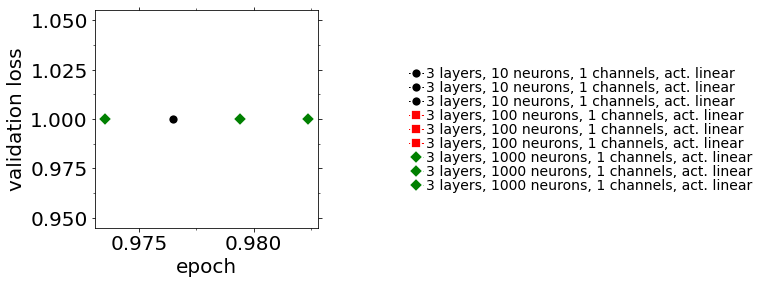

In [43]:
# def main():
# #     if eval(confParser['flags']['RemoteMachine']):
# #         return
    

    
#     #--- ann
#     number_hidden_layers  = dict(zip(range(4),[1,2,3]))
#     hidden_layer_size     = dict(zip(range(4),[10,100,1000,10000]))
#     n_channels            = dict(zip(range(4),[1]))
#     activations           = dict(zip(range(20),['linear']))
# #     string[ inums ] = "\t\'5\':\'neuralNet/20x20/ann/classifier/layer%s/channel%s/activation%s/layer_size%s\',\n" % (key_n,key_c,key_a,key_h) #--- change job name
    
#     #--- cnn
# #     number_hidden_layers  = dict(zip(range(4),[1,2,3]))
# #     hidden_layer_size     = dict(zip(range(4),[1]))
# #     n_channels            = dict(zip(range(4),[8,16,32,64]))
# #     activations           = dict(zip(range(20),['linear']))

#     runs = [0,1,2]
    
#     legend = utl.Legends()
#     legend.Set(fontsize=14,bbox_to_anchor=(2.5, 0.3, 0.5, 0.5))
#     symbols = utl.Symbols()
    
#     nphi = len(number_hidden_layers)
#     #---
#     count = 0
#     ax = utl.PltErr(None, None, Plot=False )
#     for key_n in number_hidden_layers:
#         number_hidden_layer = number_hidden_layers[key_n]
#         if number_hidden_layer != 3:
#             continue
#         for key_c in n_channels:
#             n_channel = n_channels[key_c]
# #             if n_channel != 16:
# #                 continue
#             for key_a in activations:
#                 activation = activations[key_a]
#                 for key_h in hidden_layer_size:
#                     nsize = hidden_layer_size[key_h]

#         #---	
#                     path = 'neuralNet/20x20/ann/classifier/layer%s/channel%s/activation%s/layer_size%s'%(key_n,key_c,key_a,key_h) #--- change job name
# #                     path = 'neuralNet/ni/keras/20x20/ann/classifier' #--- change job name
#                     fp = ['confusion.txt', 'val_loss_classification.txt'][0]
#                     for irun in runs:
#                         try:
#                             data = np.loadtxt('%s/Run%s/png/%s'%(path,irun,fp))
#                         except:
#                             continue

#                         if fp == 'confusion.txt':
#                             accuracy_crystals = data[0,0]/np.sum(data[0,:])
#                             accuracy_defects = data[1,1]/np.sum(data[1,:])
#                             print(data)
#                             utl.PltErr(accuracy_crystals, accuracy_defects,
#                                attrs=symbols.GetAttrs(count=count%7,nevery=800,
#                                     label='%s layers, %s neurons, %s channels, act. %s'%(number_hidden_layer,nsize,n_channel,activation)), 
#                                        Plot=False,
#                                        ax=ax,
#                                        )
#                         else:
#                             epoch = data[:,0]
#                             loss = data[:,1]
#                             val_loss = data[:,2]

#                             utl.PltErr(epoch, val_loss,
#                                attrs=symbols.GetAttrs(count=count%7,nevery=800,
#                                     label='%s layers, %s neurons, %s channels, act. %s'%(number_hidden_layer,nsize,n_channel,activation)), 
#                                        Plot=False,
#                                        ax=ax,
#                                        )
#                     count += 1
#     ax = utl.PltErr(None, None,
# #                         yscale='log',xscale='log',
#                        xstr='epoch',ystr='validation loss',
# #                     ylim=(1e-1,1e1),
#                     ax=ax,
#                     legend=legend.Get(),
#                        title='png/training_loss.png',
#                    )


# main()